lets expand our standard {'head/layout' : 'f'} to {'head/layout' : 'fa f'} for better performance
<br>
obviously, it includes (structurally) layout for basic logistic regression
<br>
and thus should work at least not worse

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../../batchflow')

from batchflow import B, V, C, Pipeline, Config
from batchflow.models.metrics import ClassificationMetrics
from batchflow.models.torch.layers import Dense
from batchflow.models.torch import TorchModel
from batchflow.opensets import MNIST
from batchflow import best_practice

In [2]:
BATCH_SIZE = 64
mnist = MNIST()

Extracting /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/train-images-idx3-ubyte.gz
Extracting /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/train-labels-idx1-ubyte.gz
 http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
Extracting /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/t10k-images-idx3-ubyte.gz
Extracting /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/t10k-labels-idx1-ubyte.gz


In [3]:
model_config_f = {
    'inputs': dict(images={'shape': (1, 28, 28),
                           'data_format': 'channels_first'},
                   labels={'classes': 10}),
    'loss': 'ce',
    'optimizer': 'Adam',
    'initial_block/inputs': 'images',
    'body/units': 10,
    'body/layout': 'f',
    'output': dict(predicted=['proba', 'labels'])
}

In [4]:
model_config_ff = model_config_f + Config({'body/layout' : 'fa f'})

In [5]:
train_pipeline = (mnist.train.p
    .init_variable('loss_history_f', init_on_each_run=list)
    .init_variable('loss_history_ff', init_on_each_run=list)
    .init_model('dynamic', TorchModel, 'f', model_config_f)
    .init_model('dynaminc', TorchModel, 'ff', model_config_ff)
    .to_array('float32', 'channels_first')
    .train_model('f', B('images'), B('labels'), fetches='loss', save_to=V('loss_history_f'), mode='a')
    .train_model('ff', B('images'), B('labels'), fetches='loss', save_to=V('loss_history_ff'), mode='a')
    .run(BATCH_SIZE, shuffle=True, n_epochs=1, bar=True)
)

100%|█████████▉| 937/938 [00:09<00:00, 96.48it/s] 


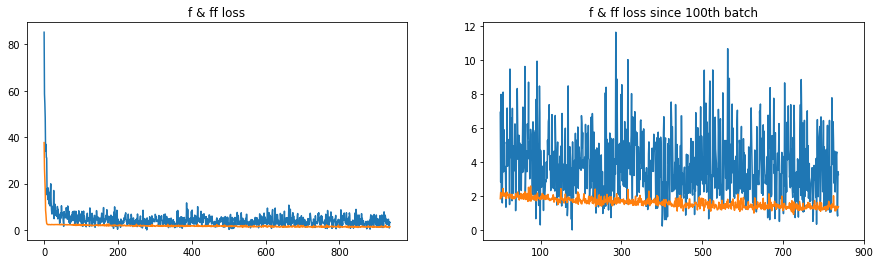

In [6]:
fig = plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(train_pipeline.get_variable('loss_history_f')[:]);
plt.plot(train_pipeline.get_variable('loss_history_ff')[:]);
plt.title('f & ff loss')

plt.subplot(1, 2, 2)
shift = 100
plt.plot(train_pipeline.get_variable('loss_history_f')[shift:]);
plt.plot(train_pipeline.get_variable('loss_history_ff')[shift:]);
plt.title(f'f & ff loss since {shift}th batch')
plt.xticks(np.arange(5)*200+100) #this is a fastfix

plt.show()

yeah, 'fa f' converges much better

In [7]:
test_pipeline = (mnist.test.p
    .init_variable('predictions_f')
    .init_variable('predictions_ff')
    .init_variable('metrics_f')
    .init_variable('metrics_ff')
    .import_model('f', train_pipeline)
    .import_model('ff', train_pipeline)
    .to_array('float32', 'channels_first')
    .predict_model('f', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_f'), mode='w')
    .predict_model('ff', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_ff'), mode='w')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_f'),
                                fmt='logits', axis=1, save_to=V('metrics_f'), mode='u')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_ff'),
                                fmt='logits', axis=1, save_to=V('metrics_ff'), mode='u')
    .run(BATCH_SIZE, n_epochs=1, bar=True)
)

 99%|█████████▉| 156/157 [00:02<00:00, 70.44it/s]


In [8]:
metrics_f = test_pipeline.get_variable('metrics_f')
metrics_ff = test_pipeline.get_variable('metrics_ff')

In [9]:
print('f:\n\n', metrics_f._confusion_matrix, '\n\nff\n\n' , metrics_ff._confusion_matrix)

f:

 [[[ 946    0    6    2    3   10   13    8   11   10]
  [   0 1092   11    0    0    1    2    4    7    4]
  [   4    6  883   17   11    3    8   17   13    3]
  [   1    5   39  893    1   40    1   24   50   14]
  [   2    1   12    7  934   18    7   18   35  208]
  [   5    7    7   65    0  767   14    2   69   22]
  [  15    4   15    2    4   12  902    0    8    0]
  [   3    1   10    7    3    0    1  919    9   37]
  [   3   19   47   14   10   40   10    8  767   54]
  [   1    0    2    3   16    1    0   28    5  657]]] 

ff

 [[[ 943    0   39    7    0   16   10    1   13    5]
  [   0 1099   30    0    0    1    3    7   12    3]
  [  11    3   45   14    7   30   24    4    5    1]
  [   0    0    1  694    0  332    0    0    0    3]
  [   0    0    0    0    0    0    0    1    0    0]
  [   0    1    2   99    2  114    0    0    0    2]
  [   3    3   77    2    7    7  844    0   11    0]
  [  22   22  819  191  966  388   77 1012  921  994]
  [   0    7  

ehm

In [10]:
metrics_f.evaluate('accuracy'), metrics_ff.evaluate('accuracy')

(0.876, 0.4761)

well, this is shit

what went wrong?
<br>
lets rerun model and observe how it performs on test during train process

In [11]:
train_pipeline = (mnist.train.p
    .init_variable('loss_history_f', init_on_each_run=list)
    .init_variable('loss_history_ff', init_on_each_run=list)
    .init_model('dynamic', TorchModel, 'f', model_config_f)
    .init_model('dynamic', TorchModel, 'ff', model_config_ff)
    .to_array('float32', 'channels_first')
    .train_model('f', B('images'), B('labels'), fetches='loss', save_to=V('loss_history_f'), mode='a')
    .train_model('ff', B('images'), B('labels'), fetches='loss', save_to=V('loss_history_ff'), mode='a')
)

In [12]:
test_template = (Pipeline()
    .init_variable('predictions_f')
    .init_variable('predictions_ff')
    .init_variable('metrics_f', init_on_each_run=None)
    .init_variable('metrics_ff', init_on_each_run=None)
    .import_model('f', train_pipeline)
    .import_model('ff', train_pipeline)
    .to_array('float32', 'channels_first')
    .predict_model('f', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_f'), mode='w')
    .predict_model('ff', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_ff'), mode='w')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_f'),
                                fmt='logits', axis=1, save_to=V('metrics_f'), mode='u')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_ff'),
                                fmt='logits', axis=1, save_to=V('metrics_ff'), mode='u')
)

In [13]:
accuracy_f = []
accuracy_ff = []
for i in range(10000):
    train_pipeline.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None)
    if (i-1) % 100 == 0:
        test_pipeline = test_template << mnist.test #temp solution, till confusion matrix update is not fixed
        test_pipeline.run(BATCH_SIZE, n_epochs=1)
        accuracy_f.append(test_pipeline.get_variable('metrics_f').evaluate('accuracy'))
        accuracy_ff.append(test_pipeline.get_variable('metrics_ff').evaluate('accuracy'))

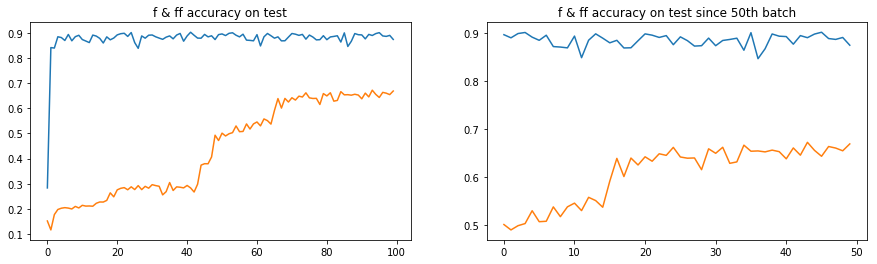

In [14]:
fig = plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(accuracy_f);
plt.plot(accuracy_ff);
plt.title('f & ff accuracy on test')

plt.subplot(1, 2, 2)
shift = 50
plt.plot(accuracy_f[shift:]);
plt.plot(accuracy_ff[shift:]);
plt.title(f'f & ff accuracy on test since {shift}th batch')

plt.show()

okay, basically it converges
<br>
sometimes
<br>
but MUCH SLOWER comparible to classic logistic regression
<br>
why?

In [15]:
train_pipeline.get_model_by_name('ff').model[0]

ConvBlock(
  (block): Sequential(
    (0): Dense(
      (linear): Linear(in_features=784, out_features=10, bias=True)
    )
    (1): Activation(
      (activation): ReLU(inplace)
    )
    (2): Dense(
      (linear): Linear(in_features=10, out_features=10, bias=True)
    )
  )
)

out_features = 10 of the first dense layer seems a bit confusing
<br>
and yes, it is the reason why fa f learns so bad
<br>
most of the weights (avg 8 of 10) are negative before the ReLU
<br>
and thus it set them to zero and second dense layer gets only 2 non-zero neurons
<br>
and on future iterations they never make it, beeing stuck on "zero-plateu" forever

so, there are at least 3 ways to avoid this situation:

In [16]:
model_config_ff_more_units = model_config_ff + Config({'body/units' : [100,10]})

In [17]:
model_config_ff_change_activation = model_config_ff + Config({'activation' : 'LeakyRelu'})

In [18]:
model_config_ff_add_normalization = model_config_ff + Config({'body/layout' : 'fan f'})

In [19]:
train_pipeline_new = (mnist.train.p
    .init_variable('loss_history_1', init_on_each_run=list)
    .init_variable('loss_history_2', init_on_each_run=list)
    .init_variable('loss_history_3', init_on_each_run=list)
    .init_model('dynamic', TorchModel, '1', model_config_ff_more_units)
    .init_model('dynamic', TorchModel, '2', model_config_ff_change_activation)
    .init_model('dynamic', TorchModel, '3', model_config_ff_add_normalization)
    .to_array('float32', 'channels_first')
    .train_model('1', B('images'), B('labels'), fetches='loss', save_to=V('loss_history_1'), mode='a')
    .train_model('2', B('images'), B('labels'), fetches='loss', save_to=V('loss_history_2'), mode='a')
    .train_model('3', B('images'), B('labels'), fetches='loss', save_to=V('loss_history_3'), mode='a')
)

In [20]:
test_template_new = (Pipeline()
    .init_variable('predictions_1')
    .init_variable('predictions_2')
    .init_variable('predictions_3')
    .init_variable('metrics_1')
    .init_variable('metrics_2')
    .init_variable('metrics_3')
    .import_model('1', train_pipeline_new)
    .import_model('2', train_pipeline_new)
    .import_model('3', train_pipeline_new)
    .to_array('float32', 'channels_first')
    .predict_model('1', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_1'), mode='w')
    .predict_model('2', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_2'), mode='w')
    .predict_model('3', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_3'), mode='w')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_1'),
                                fmt='logits', axis=1, save_to=V('metrics_1'), mode='u')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_2'),
                                fmt='logits', axis=1, save_to=V('metrics_2'), mode='u')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_3'),
                                fmt='logits', axis=1, save_to=V('metrics_3'), mode='u')
)

In [21]:
accuracy_1 = []
accuracy_2 = []
accuracy_3 = []
for i in range(10000):
    train_pipeline_new.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None)
    if (i-1) % 100 == 0:
        test_pipeline_new = test_template_new << mnist.test #temp solution, till confusion matrix update is not fixed
        test_pipeline_new.run(BATCH_SIZE, n_epochs=1)
        accuracy_1.append(test_pipeline_new.get_variable('metrics_1').evaluate('accuracy'))
        accuracy_2.append(test_pipeline_new.get_variable('metrics_2').evaluate('accuracy'))
        accuracy_3.append(test_pipeline_new.get_variable('metrics_3').evaluate('accuracy'))

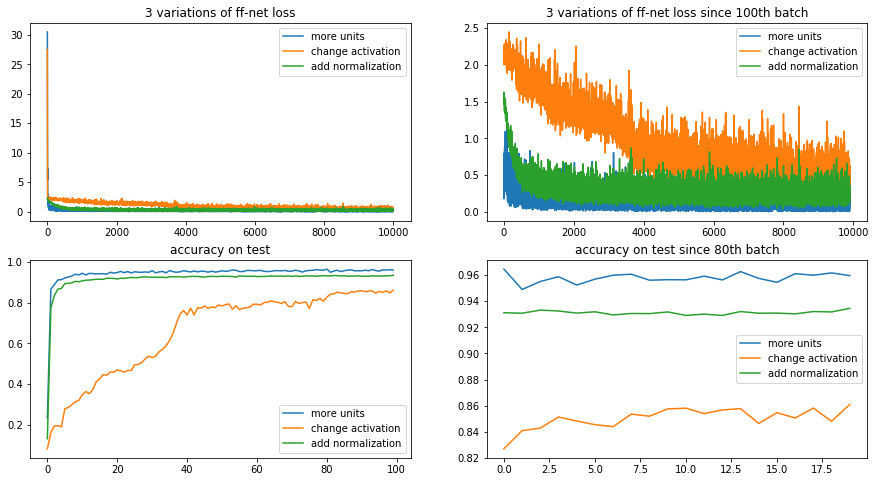

In [22]:
variations  = ['more units', 'change activation', 'add normalization']

fig = plt.figure(figsize=(15,8))

plt.subplot(2, 2, 1)
plt.plot(train_pipeline_new.get_variable('loss_history_1')[:]);
plt.plot(train_pipeline_new.get_variable('loss_history_2')[:]);
plt.plot(train_pipeline_new.get_variable('loss_history_3')[:]);
plt.title('3 variations of ff-net loss')
plt.legend(variations)

plt.subplot(2, 2, 2)
shift = 100
plt.plot(train_pipeline_new.get_variable('loss_history_1')[shift:]);
plt.plot(train_pipeline_new.get_variable('loss_history_2')[shift:]);
plt.plot(train_pipeline_new.get_variable('loss_history_3')[shift:]);
plt.title(f'3 variations of ff-net loss since {shift}th batch')
plt.legend(variations)

plt.subplot(2, 2, 3)
plt.plot(accuracy_1);
plt.plot(accuracy_2);
plt.plot(accuracy_3);
plt.title('accuracy on test')
plt.legend(variations)

plt.subplot(2, 2, 4)
shift = 80
plt.plot(accuracy_1[shift:]);
plt.plot(accuracy_2[shift:]);
plt.plot(accuracy_3[shift:]);
plt.title(f'accuracy on test since {shift}th batch')
plt.legend(variations)

plt.show()

In [23]:
test_pipeline_new = (mnist.test.p
    .init_variable('predictions_1')
    .init_variable('predictions_2')
    .init_variable('predictions_3')
    .init_variable('metrics_1')
    .init_variable('metrics_2')
    .init_variable('metrics_3')
    .import_model('1', train_pipeline_new)
    .import_model('2', train_pipeline_new)
    .import_model('3', train_pipeline_new)
    .to_array('float32', 'channels_first')
    .predict_model('1', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_1'), mode='w')
    .predict_model('2', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_2'), mode='w')
    .predict_model('3', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_3'), mode='w')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_1'),
                                fmt='logits', axis=1, save_to=V('metrics_1'), mode='u')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_2'),
                                fmt='logits', axis=1, save_to=V('metrics_2'), mode='u')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_3'),
                                fmt='logits', axis=1, save_to=V('metrics_3'), mode='u')
    .run(BATCH_SIZE, n_epochs=1, bar=True)
)

 99%|█████████▉| 156/157 [00:01<00:00, 151.03it/s]


In [24]:
metrics_1 = test_pipeline_new.get_variable('metrics_1')
metrics_2 = test_pipeline_new.get_variable('metrics_2')
metrics_3 = test_pipeline_new.get_variable('metrics_3')

In [25]:
print(variations[0], ':\n\n', metrics_1._confusion_matrix, '\n\n',
      variations[1], ':\n\n' , metrics_2._confusion_matrix, '\n\n',
      variations[2], ':\n\n', metrics_3._confusion_matrix)

more units :

 [[[ 961    0    5    0    1    2    4    2    3    5]
  [   1 1114    9    0    0    0    2    1    0    3]
  [   1    2  978    8    6    1    0   13    4    1]
  [   1    3   22  986    0   24    1   22   41   32]
  [   3    0    1    0  951    0    6    5    4   12]
  [   3    2    1    9    0  847   11    0   25    4]
  [   5    4    1    0    4   10  929    0    3    0]
  [   4    0    3    0    2    1    0  955    0   12]
  [   1    9   12    5    4    5    5    4  893    5]
  [   0    1    0    2   14    2    0   26    1  935]]] 

 change activation :

 [[[ 934    0   12    0    1   22   17    7   89   11]
  [   0 1101   25   20    7    2    3   25   17    3]
  [   3   13  897   42    2    8    4   16   87    0]
  [   0    5   16  899    0  156    0   15   44   18]
  [   4    2   17    3  935   58   26    9   89  159]
  [   0    4    0   26    0  572    8    0   15    2]
  [  10    2   15    0    8   14  887    0   34    0]
  [   0    1    5    7    1    0    0  8

In [26]:
metrics_1.evaluate('accuracy'), metrics_2.evaluate('accuracy'), metrics_3.evaluate('accuracy')

(0.9549, 0.8447, 0.9326)

thats better